In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [2]:
import _pickle as cPickle

In [3]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

In [4]:
raw_data = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/dataset.pkl')

data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

# Label one

In [5]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:

        return -1
    else:   
        return 0

In [6]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

In [7]:
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1


In [8]:
df_1 = data.loc['2001-01-01':'2004-01-01']
df_valid = data.loc['2004-04-01':'2004-07-01']
df_test = data.loc['2004-10-01':'2005-01-01']

In [9]:
df_valid.reset_index(inplace=True,)
df_valid.set_index(['date'],inplace=True)
df_valid.index

DatetimeIndex(['2004-04-01', '2004-04-01', '2004-04-01', '2004-04-01',
               '2004-04-01', '2004-04-01', '2004-04-02', '2004-04-02',
               '2004-04-05', '2004-04-07',
               ...
               '2004-06-30', '2004-06-30', '2004-06-30', '2004-07-01',
               '2004-07-01', '2004-07-01', '2004-07-01', '2004-07-01',
               '2004-07-01', '2004-07-01'],
              dtype='datetime64[ns]', name='date', length=1155, freq=None)

In [10]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [11]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

In [12]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [13]:
optimal_hyperparameters = []

## Optimal hyparameters using accuracy

In [34]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,5)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
 
    return accuracy

In [35]:
study = optuna.create_study(direction="maximize")
from functools import partial

In [36]:
%%time
study.optimize(partial(objective,train=train_1,labels=y_1,val=valid,val_labels=y_valid,
                       val_rets=valid_stock_returns), n_trials=25,n_jobs=-1)

CPU times: user 22min 25s, sys: 25 s, total: 22min 50s
Wall time: 8min 16s


In [37]:
study.best_params

{'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.4}

In [14]:
optimal_hyperparameters.append({'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.4})

## Optimal hyparameters using profit

In [53]:
def objective1(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,5)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    profit = (preds * val_rets).sum()

    return profit

In [54]:
study = optuna.create_study(direction="maximize")
from functools import partial

In [55]:
%%time
study.optimize(partial(objective1,train=train_1,labels=y_1,val=valid,
                       val_labels=y_valid,val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)

CPU times: user 17min 11s, sys: 13.8 s, total: 17min 25s
Wall time: 5min 26s


In [58]:
study.best_params

{'max_depth': 5, 'n_estimators': 10, 'learning_rate': 0.5}

In [15]:
optimal_hyperparameters.append({'max_depth': 5, 'n_estimators': 10, 'learning_rate': 0.5})

## Optimal hyperparameter using max_drawdown

In [60]:
# 3 month periods from 2004-04-01 to 2004-07-01
start_dates = [pd.to_datetime('2004-04-01') + pd.DateOffset(months = i) for i in range(3)]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 1)] for d in start_dates]

valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

validation_labels = [d['rel_performance'].values for d in valid_frames]

In [61]:
start_dates

[Timestamp('2004-04-01 00:00:00'),
 Timestamp('2004-05-01 00:00:00'),
 Timestamp('2004-06-01 00:00:00')]

In [29]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [46]:
def objective2(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,5)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")
    ada_clf.fit(train,labels)
    
    x = [1]
    for i in range(len(start_dates)):
        pred_i = ada_clf.predict(valid_data[i])
        profit_i = (pred_i * valid_frames[i]['next_period_return']).sum()
        positions = np.sum(np.abs(pred_i))
        x.append(x[i] + (x[i]/positions) * profit_i)
    return -max_drawdown(x)

In [47]:
study = optuna.create_study(direction="maximize")
from functools import partial

In [48]:
%%time
study.optimize(partial(objective2,train=train_1,labels=y_1,val=valid,
                       val_labels=y_valid,val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)

CPU times: user 25min 9s, sys: 20.3 s, total: 25min 29s
Wall time: 8min 4s


In [49]:
study.best_params

{'max_depth': 5, 'n_estimators': 90, 'learning_rate': 0.2}

In [16]:
optimal_hyperparameters.append({'max_depth': 5, 'n_estimators': 90, 'learning_rate': 0.2})

In [17]:
optimal_hyperparameters

[{'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.4},
 {'max_depth': 5, 'n_estimators': 10, 'learning_rate': 0.5},
 {'max_depth': 5, 'n_estimators': 90, 'learning_rate': 0.2}]

In [18]:
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=50,learning_rate=0.4)
classifier1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=10,learning_rate=0.5)
classifier2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=90,learning_rate=0.2)

## Using optimal features and optimal hyperparameters (accuracy) to calculate max_drawdown

In [19]:
with open(r'shap_features_ada.pkl','rb') as f:
    shap_features = cPickle.load(f)

In [20]:
with open(r'shap_features_ada_01.pkl','rb') as f:
    shap_features1 = cPickle.load(f)

In [21]:
with open(r'shap_features_ada_02.pkl','rb') as f:
    shap_features2 = cPickle.load(f)

In [22]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [23]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])

In [24]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data2 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),
                                   columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data2 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),
                                columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data2 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),
                               columns=shap_features[i]) for i in range(len(start_dates)-1)]

In [25]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data1 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features1[i]].values),
                                   columns=shap_features1[i]) for i in range(len(start_dates)-1)]
opt_valid_data1 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features1[i]].values),
                                columns=shap_features1[i]) for i in range(len(start_dates)-1)]
opt_test_data1 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features1[i]].values),
                               columns=shap_features1[i]) for i in range(len(start_dates)-1)]

In [26]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features2[i]].values),
                                  columns=shap_features2[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features2[i]].values),
                               columns=shap_features2[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features2[i]].values),
                              columns=shap_features2[i]) for i in range(len(start_dates)-1)]

### optimal feature set 1

In [76]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifier.fit(opt_training_data[i],training_labels[i])

        preds = classifier.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

In [78]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

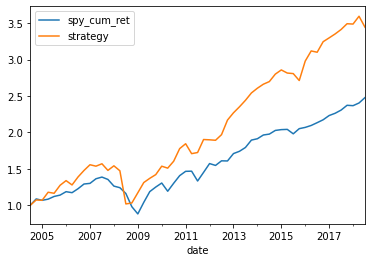

In [80]:
SPY.plot();

In [81]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.41400937736909804


In [97]:
# starting_year='2005'
# b = SPY.loc[starting_year]['strategy'].values
# max_drawdown((SPY.loc[starting_year:]['strategy'] - b + 1).values)
max_drawdown(SPY['strategy'])

0.5228390771394471

### optimal feature set 2

In [137]:
x1 = [1]
ret1 = []

for i in range(len(start_dates)-1):
        
        classifier.fit(opt_training_data1[i],training_labels[i])

        preds = classifier.predict(opt_test_data1[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret1.append(profit_i)
        num_names = len(opt_test_data1[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)

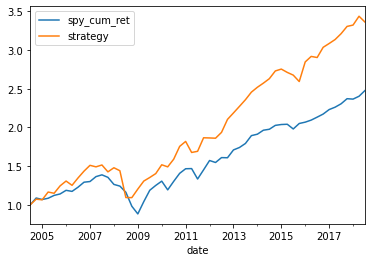

In [138]:
SPY['strategy'] = x1
SPY.plot();

In [139]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.4698737430730971


In [140]:
# starting_year='2005'
# b = SPY.loc[starting_year]['strategy'].values
# max_drawdown((SPY.loc[starting_year:]['strategy'] - b + 1).values)
max_drawdown(SPY['strategy'])

0.38650269253175384

### optimal feature set 3

In [141]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifier.fit(opt_training_data2[i],training_labels[i])

        preds = classifier.predict(opt_test_data2[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data2[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)

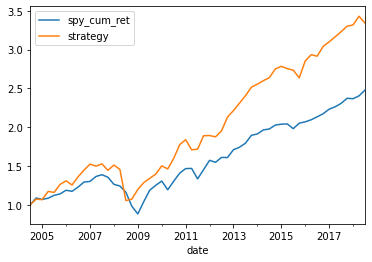

In [143]:
SPY['strategy'] = x2
SPY.plot();

In [144]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.44147782487587045


In [145]:
# starting_year='2005'
# b = SPY.loc[starting_year]['strategy'].values
# max_drawdown((SPY.loc[starting_year:]['strategy'] - b + 1).values)
max_drawdown(SPY['strategy'])

0.4573367224384044

## Using optimal features and optimal hyperparameters (profit) to calculate max_drawdown

### optimal feature set 1

In [148]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifier1.fit(opt_training_data[i],training_labels[i])

        preds = classifier1.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.3647875046896272
Maximun drawdown:  0.5319013004746018


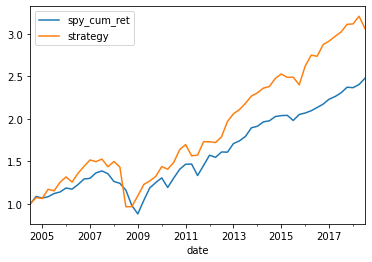

In [149]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

### optimal feature set 2

In [150]:
x1 = [1]
ret1 = []

for i in range(len(start_dates)-1):
        
        classifier1.fit(opt_training_data1[i],training_labels[i])

        preds = classifier1.predict(opt_test_data1[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret1.append(profit_i)
        num_names = len(opt_test_data1[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.450666269039878
Maximun drawdown:  0.4000991051766989


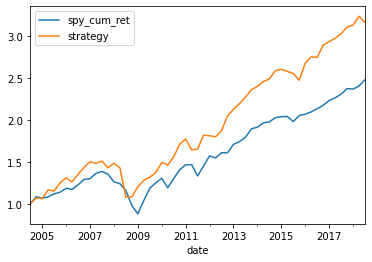

In [151]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x1

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

### optimal feature set 3

In [152]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifier1.fit(opt_training_data2[i],training_labels[i])

        preds = classifier1.predict(opt_test_data2[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data2[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.45609554793891327
Maximun drawdown:  0.40495392348912573


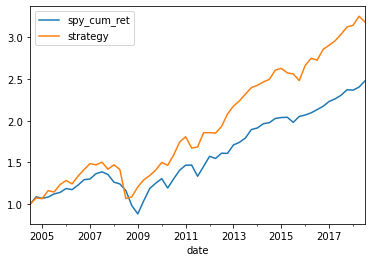

In [153]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x2

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

## Using optimal features and optimal hyperparameters (max_drawdown) to calculate max_drawdown

### optimal feature set 1

In [27]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifier2.fit(opt_training_data[i],training_labels[i])

        preds = classifier2.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.4211671578126219
Maximun drawdown:  0.38558697034197364


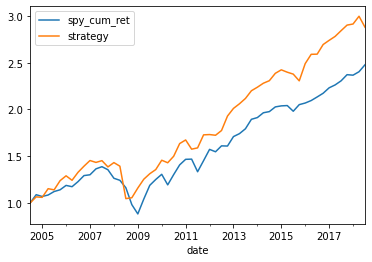

In [30]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

### optimal feature set 2

In [31]:
x1 = [1]
ret1 = []

for i in range(len(start_dates)-1):
        
        classifier2.fit(opt_training_data1[i],training_labels[i])

        preds = classifier2.predict(opt_test_data1[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret1.append(profit_i)
        num_names = len(opt_test_data1[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.44613388888909505
Maximun drawdown:  0.30042090455229964


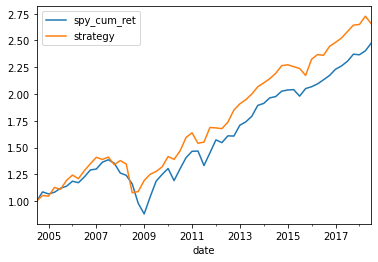

In [32]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x1

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

### optimal feature set 3

In [33]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifier2.fit(opt_training_data2[i],training_labels[i])

        preds = classifier2.predict(opt_test_data2[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data2[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.41305808405569466
Maximun drawdown:  0.34928564271876916


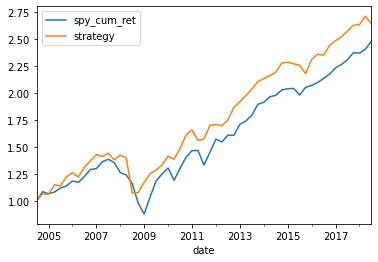

In [34]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x2

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

# Label two

In [35]:
def f(x):
    if x > 0.05:
        return 1
    elif x < -0.1:
        return -1
    else: 
        return 0

In [36]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

In [37]:
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,0
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_1 = data.loc['2001-01-01':'2004-01-01']
df_valid = data.loc['2004-04-01':'2004-07-01']
df_test = data.loc['2004-10-01':'2005-01-01']

df_valid.reset_index(inplace=True,)
df_valid.set_index(['date'],inplace=True)
df_valid.index

train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

In [39]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [40]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
    
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data2 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),
                                   columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data2 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),
                                columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data2 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),
                               columns=shap_features[i]) for i in range(len(start_dates)-1)]

opt_training_data1 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features1[i]].values),
                                   columns=shap_features1[i]) for i in range(len(start_dates)-1)]
opt_valid_data1 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features1[i]].values),
                                columns=shap_features1[i]) for i in range(len(start_dates)-1)]
opt_test_data1 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features1[i]].values),
                               columns=shap_features1[i]) for i in range(len(start_dates)-1)]

opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features2[i]].values),
                                  columns=shap_features2[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features2[i]].values),
                               columns=shap_features2[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features2[i]].values),
                              columns=shap_features2[i]) for i in range(len(start_dates)-1)]

## Using optimal features and optimal hyperparameters (accuracy) to calculate max_drawdown

In [41]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifier.fit(opt_training_data[i],training_labels[i])

        preds = classifier.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.4277191444375892
Maximun drawdown:  0.0969301815465693


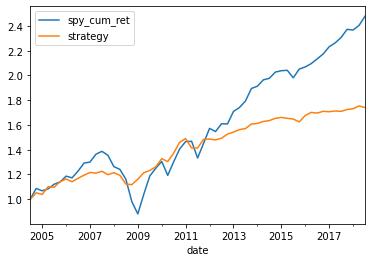

In [42]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [43]:
x1 = [1]
ret1 = []

for i in range(len(start_dates)-1):
        
        classifier.fit(opt_training_data1[i],training_labels[i])

        preds = classifier.predict(opt_test_data1[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret1.append(profit_i)
        num_names = len(opt_test_data1[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.41907216569408073
Maximun drawdown:  0.11228168687087692


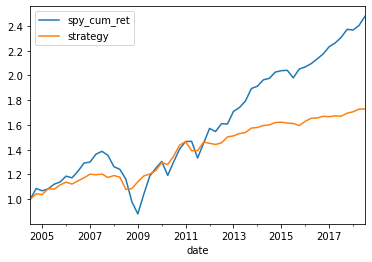

In [44]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x1

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [45]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifier.fit(opt_training_data2[i],training_labels[i])

        preds = classifier.predict(opt_test_data2[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data2[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.3763714509647855
Maximun drawdown:  0.11768538766931314


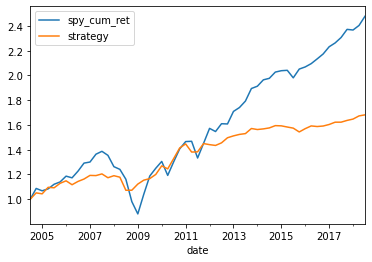

In [46]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x2

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

## Using optimal features and optimal hyperparameters (profit) to calculate max_drawdown

In [47]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifier1.fit(opt_training_data[i],training_labels[i])

        preds = classifier1.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.4264825975313931
Maximun drawdown:  0.09987313702341871


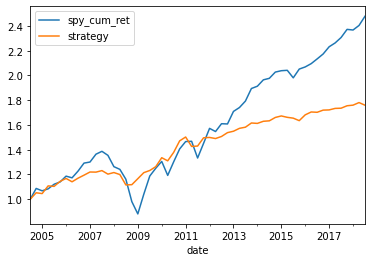

In [48]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [49]:
x1 = [1]
ret1 = []

for i in range(len(start_dates)-1):
        
        classifier1.fit(opt_training_data1[i],training_labels[i])

        preds = classifier1.predict(opt_test_data1[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret1.append(profit_i)
        num_names = len(opt_test_data1[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.4756336161557262
Maximun drawdown:  0.08072273345687009


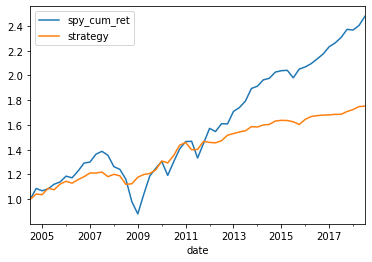

In [50]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x1

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [51]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifier1.fit(opt_training_data2[i],training_labels[i])

        preds = classifier1.predict(opt_test_data2[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data2[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.37113587984768553
Maximun drawdown:  0.13282853164978548


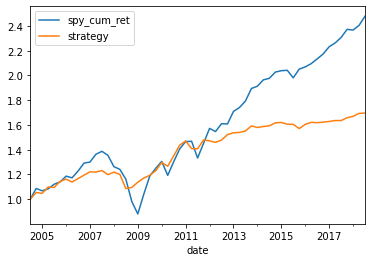

In [52]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x2

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

## Using optimal features and optimal hyperparameters (max_drawdown) to calculate max_drawdown

In [53]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifier2.fit(opt_training_data[i],training_labels[i])

        preds = classifier2.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.43146717623116354
Maximun drawdown:  0.12109339333460456


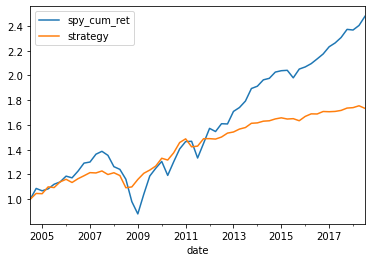

In [54]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [55]:
x1 = [1]
ret1 = []

for i in range(len(start_dates)-1):
        
        classifier2.fit(opt_training_data1[i],training_labels[i])

        preds = classifier2.predict(opt_test_data1[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret1.append(profit_i)
        num_names = len(opt_test_data1[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.4395066498042709
Maximun drawdown:  0.11651612123397204


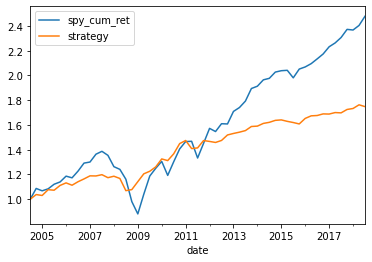

In [56]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x1

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [57]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifier2.fit(opt_training_data2[i],training_labels[i])

        preds = classifier2.predict(opt_test_data2[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data2[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.3816610015115955
Maximun drawdown:  0.1290341490525857


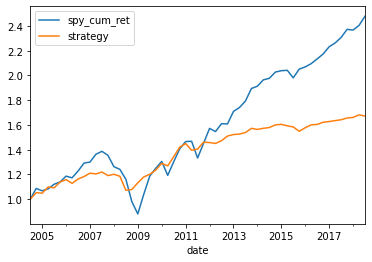

In [58]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x2

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

# Label three

In [59]:
def f(x):
    if x > 0.05:
        return 2
    elif x > 0.01 and x < 0.05:
        return 1
    elif x > -0.01 and x < 0.01:
        return 0
    elif x > -0.05 and x < -0.01:
        return -1
    else: 
        return -2

In [60]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

In [61]:
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,2
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,2
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,2
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1


In [62]:
df_1 = data.loc['2001-01-01':'2004-01-01']
df_valid = data.loc['2004-04-01':'2004-07-01']
df_test = data.loc['2004-10-01':'2005-01-01']

df_valid.reset_index(inplace=True,)
df_valid.set_index(['date'],inplace=True)
df_valid.index

train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

In [63]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [64]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
    
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data2 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),
                                   columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data2 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),
                                columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data2 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),
                               columns=shap_features[i]) for i in range(len(start_dates)-1)]

opt_training_data1 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features1[i]].values),
                                   columns=shap_features1[i]) for i in range(len(start_dates)-1)]
opt_valid_data1 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features1[i]].values),
                                columns=shap_features1[i]) for i in range(len(start_dates)-1)]
opt_test_data1 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features1[i]].values),
                               columns=shap_features1[i]) for i in range(len(start_dates)-1)]

opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features2[i]].values),
                                  columns=shap_features2[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features2[i]].values),
                               columns=shap_features2[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features2[i]].values),
                              columns=shap_features2[i]) for i in range(len(start_dates)-1)]

## Using optimal features and optimal hyperparameters (accuracy) to calculate max_drawdown

In [65]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifier.fit(opt_training_data[i],training_labels[i])

        preds = classifier.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.3800910707489083
Maximun drawdown:  1.255723666295912


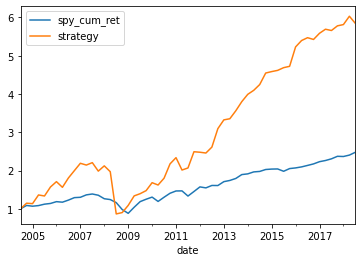

In [66]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [67]:
x1 = [1]
ret1 = []

for i in range(len(start_dates)-1):
        
        classifier.fit(opt_training_data1[i],training_labels[i])

        preds = classifier.predict(opt_test_data1[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret1.append(profit_i)
        num_names = len(opt_test_data1[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.521222799442494
Maximun drawdown:  0.8426421151947654


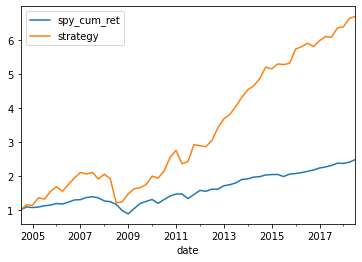

In [68]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x1

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [69]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifier.fit(opt_training_data2[i],training_labels[i])

        preds = classifier.predict(opt_test_data2[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data2[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.44501562390039634
Maximun drawdown:  0.9927420407609904


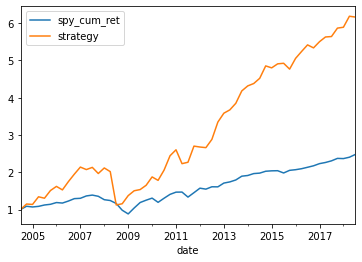

In [70]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x2

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

## Using optimal features and optimal hyperparameters (profit) to calculate max_drawdown

In [71]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifier1.fit(opt_training_data[i],training_labels[i])

        preds = classifier1.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.2977329384227532
Maximun drawdown:  1.2588266363410843


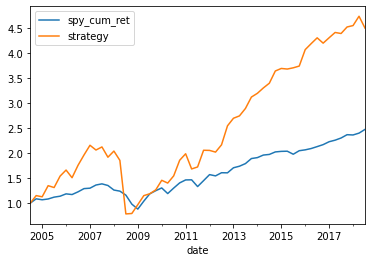

In [72]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [73]:
x1 = [1]
ret1 = []

for i in range(len(start_dates)-1):
        
        classifier1.fit(opt_training_data1[i],training_labels[i])

        preds = classifier1.predict(opt_test_data1[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret1.append(profit_i)
        num_names = len(opt_test_data1[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.5120642872936364
Maximun drawdown:  0.6063507495164087


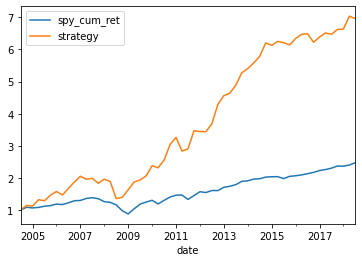

In [74]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x1

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [75]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifier1.fit(opt_training_data2[i],training_labels[i])

        preds = classifier1.predict(opt_test_data2[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data2[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.4118028021175335
Maximun drawdown:  0.9118642020032912


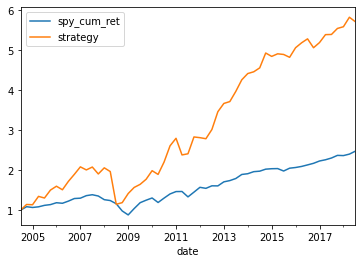

In [76]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x2

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

## Using optimal features and optimal hyperparameters (max_drawdown) to calculate max_drawdown

In [77]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifier2.fit(opt_training_data[i],training_labels[i])

        preds = classifier2.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.3611810141509789
Maximun drawdown:  0.8738852878471617


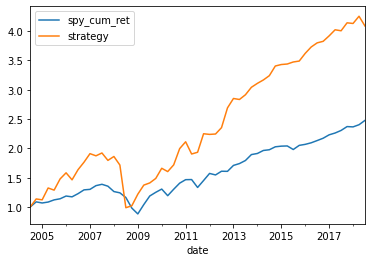

In [78]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [79]:
x1 = [1]
ret1 = []

for i in range(len(start_dates)-1):
        
        classifier2.fit(opt_training_data1[i],training_labels[i])

        preds = classifier2.predict(opt_test_data1[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret1.append(profit_i)
        num_names = len(opt_test_data1[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.4694009413933545
Maximun drawdown:  0.5976551500284832


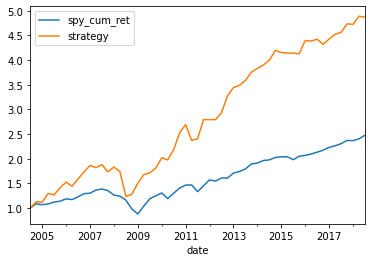

In [80]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x1

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))

In [81]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifier2.fit(opt_training_data2[i],training_labels[i])

        preds = classifier2.predict(opt_test_data2[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data2[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)

Strategy Sharpe Ratio:  0.4078292541991819
Maximun drawdown:  0.715475308044055


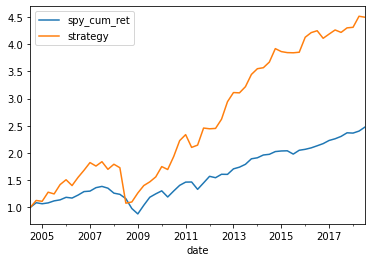

In [82]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/lec10/hw3/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x2

SPY.plot();

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

print('Maximun drawdown: ', max_drawdown(SPY['strategy']))